In [1]:
import pandas as pd
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import numpy as np
import numpy as np

## Functions

In [10]:
def calculate_macd_signals(df, initial_capital=100):
    #remove first 1 row
    df = df.iloc[1:]
    # Calculate EMAs
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD and Signal Line
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Generate Buy, Sell, Hold signals
    df['Buy'] = np.where(df['MACD'] > df['Signal'], 1, 0)
    df['Sell'] = np.where(df['MACD'] < df['Signal'], 1, 0)
    df['Hold'] = np.where(df['MACD'] == df['Signal'], 1, 0)
    
    # Initialize trade flags and counter
    buy_flag = False
    hold_flag = False
    sell_flag = True
    days_count = 0
    
    df['Trades'] = 'Hold'
    
    # Initialize capital variables
    current_capital = initial_capital
    buy_price = None
    
    df['Capital'] = current_capital
    
    # Calculate trades and returns in the same loop
    for index, row in df.iterrows():
        if row['Buy'] == 1:
            if sell_flag:
                buy_flag = True
                hold_flag = False
                sell_flag = False
                days_count = 0
                df.at[index, 'Trades'] = 'Buy'
                buy_price = row['Close']
        elif buy_flag:
            if row['Sell'] == 1 or days_count == 11:
                buy_flag = False
                hold_flag = False
                sell_flag = True
                df.at[index, 'Trades'] = 'Sell'
                if buy_price is not None:
                    trade_return = (row['Close'] - buy_price) / buy_price
                    current_capital += current_capital * trade_return
                    buy_price = None
            else:
                hold_flag = True
                df.at[index, 'Trades'] = 'Hold'
                days_count += 1
        else:
            df.at[index, 'Trades'] = 'Hold'
        
        # Update the capital in the DataFrame
        df.at[index, 'Capital'] = current_capital
    
    # Print final results
    final_capital = df.iloc[-1]['Capital']
    overall_return = final_capital - initial_capital
    
    print(f"Final Capital: {final_capital}")
    print(f"Overall Return: {overall_return}")
    print(f"Overall Return %: {overall_return/initial_capital*100}")
    #print number of days
    print(f"Number of Days: {df.shape[0]}")
    #print number of trades
    print(f"Number of Trades: {df[df['Trades'] != 'Hold'].shape[0]}")
    print("Ratio of Trades to Days: ", df[df['Trades'] != 'Hold'].shape[0]/df.shape[0])
    print("----------------------------------------"+'\n')
    
    df.rename(columns={'Trades': 'Trades_MACD', 'Capital':'Capital_MACD'}, inplace=True)
    return df[['Open', 'High', 'Low', 'Close', 'Volume','Trades_MACD', 'Capital_MACD']]

# Function to find Sell and Buy points
def profit_trades(df):
    df['Trades_Profit'] = 'Hold'
    df.sort_index(inplace=True, ascending=False)
    i = 0
    while i < len(df):
        # Select the highest value in Close in the next 12 rows for a Sell
        max_idx = df.iloc[i:i+12]['Close'].idxmax()
        df.at[max_idx, 'Trades_Profit'] = 'Sell'
        i = df.index.get_loc(max_idx) + 1
        
        if i >= len(df):
            break
        
        # Select the lowest value in Close in the next 11 rows for a Buy
        min_idx = df.iloc[i:i+11]['Close'].idxmin()
        df.at[min_idx, 'Trades_Profit'] = 'Buy'
        i = df.index.get_loc(min_idx) + 1

    df.sort_index(inplace=True, ascending=True)


    # Calculate the capital
    current_capital = 100
    buy_price = None
    df['Capital_Profit'] = current_capital

    for index, row in df.iterrows():
        if row['Trades_Profit'] == 'Buy':
            buy_price = row['Close']
        elif row['Trades_Profit'] == 'Sell':
            if buy_price is not None:
                trade_return = (row['Close'] - buy_price) / buy_price
                current_capital += current_capital * trade_return
                buy_price = None
        df.at[index, 'Capital_Profit'] = current_capital

    print(f"Final Capital: {current_capital}")
    print(f"Overall Return: {current_capital - 100}")
    print(f"Overall Return %: {(current_capital - 100)/100*100}")
    print(f"Number of Days: {df.shape[0]}")
    print(f"Number of Trades: {df[df['Trades_Profit'] != 'Hold'].shape[0]}")
    print("Ratio of Trades to Days: ", df[df['Trades_Profit'] != 'Hold'].shape[0]/df.shape[0])
    print("----------------------------------------"+'\n')


    return df

# Function to find Sell and Buy points
def loss_trades(df):
    df['Trades_Loss'] = 'Hold'
    df.sort_index(inplace=True, ascending=False)
    i = 0
    while i < len(df):
        # Select the highest value in Close in the next 12 rows for a Sell
        min_idx = df.iloc[i:i+12]['Close'].idxmin()
        df.at[min_idx, 'Trades_Loss'] = 'Sell'
        i = df.index.get_loc(min_idx) + 1
        
        if i >= len(df):
            break
        
        # Select the lowest value in Close in the next 11 rows for a Buy
        max_idx = df.iloc[i:i+11]['Close'].idxmax()
        df.at[max_idx, 'Trades_Loss'] = 'Buy'
        i = df.index.get_loc(max_idx) + 1

    df.sort_index(inplace=True, ascending=True)


    # Calculate the capital
    current_capital = 100
    buy_price = None
    df['Capital_Loss'] = current_capital

    for index, row in df.iterrows():
        if row['Trades_Loss'] == 'Buy':
            buy_price = row['Close']
        elif row['Trades_Loss'] == 'Sell':
            if buy_price is not None:
                trade_return = (row['Close'] - buy_price) / buy_price
                current_capital += current_capital * trade_return
                buy_price = None
        df.at[index, 'Capital_Loss'] = current_capital

    print(f"Final Capital: {current_capital}")
    print(f"Overall Return: {current_capital - 100}")
    print(f"Overall Return %: {(current_capital - 100)/100*100}")
    print(f"Number of Days: {df.shape[0]}")
    print(f"Number of Trades: {df[df['Trades_Loss'] != 'Hold'].shape[0]}")
    print("Ratio of Trades to Days: ", df[df['Trades_Loss'] != 'Hold'].shape[0]/df.shape[0])
    print("----------------------------------------"+'\n')

    return df


def plot_trades(df, trades_column):
    """
    Plot Buy and Sell signals over time using plotly.

    Args:
    - df (pd.DataFrame): DataFrame containing Date index and 'trades' column.
    - trades_column (str): Name of the column containing 'Buy', 'Sell', or 'Hold' signals.

    Returns:
    - None (displays the plot interactively).
    """
    # Filter out 'Hold' trades
    df_filtered = df[df[trades_column].isin(['Buy', 'Sell'])]

    # Map trades to colors for visualization
    color_map = {'Buy': 'green', 'Sell': 'red'}

    # Create figure
    fig = go.Figure()

    # Add scatter trace for Buys and Sells
    for trade_type in ['Buy', 'Sell']:
        trade_data = df_filtered[df_filtered[trades_column] == trade_type]
        fig.add_trace(go.Scatter(
            x=trade_data.index,
            y=[1] * len(trade_data),  # Dummy y-value for scatter plot
            mode='markers',
            marker=dict(color=color_map[trade_type], size=10, symbol='triangle-up' if trade_type == 'Buy' else 'triangle-down'),
            name=trade_type
        ))

    # Update layout
    fig.update_layout(
        title='Buy and Sell Signals Over Time',
        xaxis_title='Date',
        yaxis_title='Trading Signal',
        yaxis=dict(
            tickvals=[1],
            ticktext=['Trading Signal'],
            showticklabels=True
        ),
        showlegend=True
    )

    # Show plot
    fig.show()


## Code

In [11]:
df_sp = pd.read_pickle('data/SP500.pkl')
df_nifty = pd.read_pickle('data/NIFTY50.pkl')
df_ftse = pd.read_pickle('data/FTSE100.pkl')

In [12]:
print("S&P 500")
df_sp = calculate_macd_signals(df_sp)
print("Nifty 50")
df_nifty = calculate_macd_signals(df_nifty)
print("FTSE 100")
df_ftse = calculate_macd_signals(df_ftse)

S&P 500
Final Capital: 224.64428767962227
Overall Return: 124.64428767962227
Overall Return %: 124.64428767962225
Number of Days: 5032
Number of Trades: 429
Ratio of Trades to Days:  0.0852543720190779
----------------------------------------

Nifty 50
Final Capital: 272.1472011791652
Overall Return: 172.14720117916522
Overall Return %: 172.14720117916522
Number of Days: 4051
Number of Trades: 306
Ratio of Trades to Days:  0.07553690446803259
----------------------------------------

FTSE 100
Final Capital: 141.7153877086282
Overall Return: 41.715387708628214
Overall Return %: 41.715387708628214
Number of Days: 5049
Number of Trades: 397
Ratio of Trades to Days:  0.07862943157060805
----------------------------------------



In [13]:
print("S&P 500")
df_sp = profit_trades(df_sp)
print("Nifty 50")
df_nifty = profit_trades(df_nifty)
print("FTSE 100")
df_ftse = profit_trades(df_ftse)

S&P 500
Final Capital: 23653934.29102255
Overall Return: 23653834.29102255
Overall Return %: 23653834.29102255
Number of Days: 5032
Number of Trades: 728
Ratio of Trades to Days:  0.14467408585055644
----------------------------------------

Nifty 50
Final Capital: 16358960.70749188
Overall Return: 16358860.70749188
Overall Return %: 16358860.70749188
Number of Days: 4051
Number of Trades: 564
Ratio of Trades to Days:  0.13922488274500122
----------------------------------------

FTSE 100
Final Capital: 10941911.17274477
Overall Return: 10941811.17274477
Overall Return %: 10941811.17274477
Number of Days: 5049
Number of Trades: 718
Ratio of Trades to Days:  0.14220637750049514
----------------------------------------



In [14]:
print("S&P 500")
df_sp = loss_trades(df_sp)
print("Nifty 50")
df_nifty = loss_trades(df_nifty)
print("FTSE 100")
df_ftse = loss_trades(df_ftse)

S&P 500
Final Capital: 0.001688384067967603
Overall Return: -99.99831161593204
Overall Return %: -99.99831161593204
Number of Days: 5032
Number of Trades: 713
Ratio of Trades to Days:  0.1416931637519873
----------------------------------------

Nifty 50
Final Capital: 0.0027223856272026743
Overall Return: -99.99727761437279
Overall Return %: -99.99727761437279
Number of Days: 4051
Number of Trades: 563
Ratio of Trades to Days:  0.13897803011602072
----------------------------------------

FTSE 100
Final Capital: 0.0016702594772402437
Overall Return: -99.99832974052276
Overall Return %: -99.99832974052276
Number of Days: 5049
Number of Trades: 699
Ratio of Trades to Days:  0.1384432560903149
----------------------------------------



In [15]:
df_sp.head(10)

,Open,High,Low,Close,Volume,Trades_MACD,Capital_MACD,Trades_Profit,Capital_Profit,Trades_Loss,Capital_Loss
Date,,,,,,,,,,,
2004-04-01,1126.209961,1135.670044,1126.199951,1132.170044,1560700000,Hold,100.000000,Buy,100.000000,Sell,100.0
2004-04-02,1132.170044,1144.810059,1132.170044,1141.810059,1629200000,Buy,100.000000,Hold,100.000000,Hold,100.0
2004-04-05,1141.810059,1150.569946,1141.640015,1150.569946,1413700000,Hold,100.000000,Sell,101.625189,Buy,100.0
2004-04-06,1150.569946,1150.569946,1143.300049,1148.160034,1397700000,Hold,100.000000,Hold,101.625189,Hold,100.0
2004-04-07,1148.160034,1148.160034,1138.410034,1140.530029,1458800000,Hold,100.000000,Hold,101.625189,Hold,100.0
2004-04-08,1140.530029,1148.969971,1134.520020,1139.319946,1199800000,Hold,100.000000,Hold,101.625189,Hold,100.0
2004-04-12,1139.319946,1147.290039,1139.319946,1145.199951,1102400000,Hold,100.000000,Hold,101.625189,Hold,100.0
2004-04-13,1145.199951,1147.780029,1127.699951,1129.439941,1423200000,Hold,100.000000,Hold,101.625189,Hold,100.0
2004-04-14,1129.439941,1132.520020,1122.150024,1128.170044,1547700000,Sell,98.805404,Hold,101.625189,Hold,100.0


<Axes: xlabel='Date'>

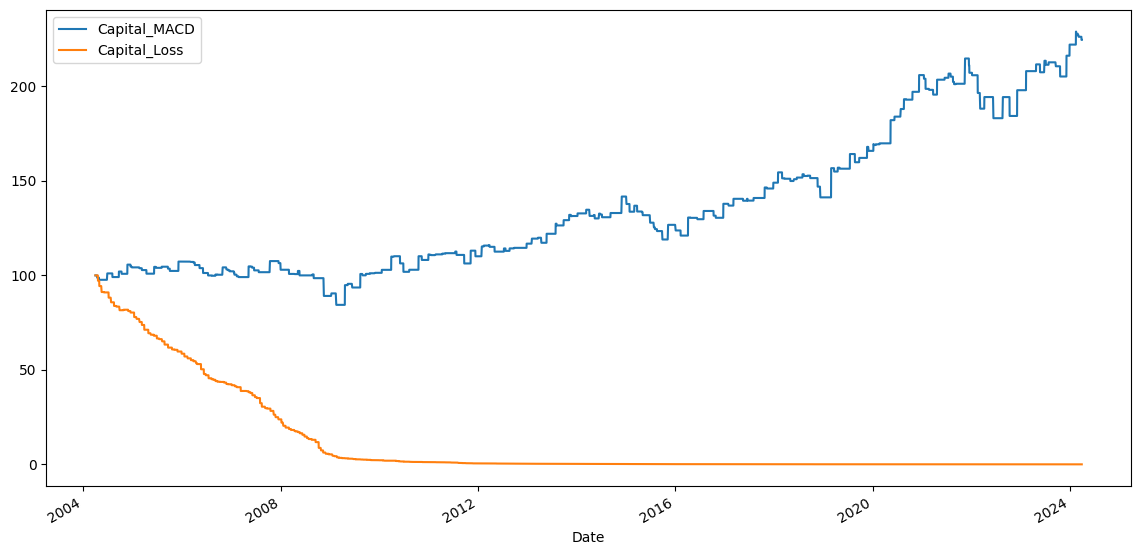

In [7]:
df_sp[['Capital_MACD', 'Capital_Loss']].plot(figsize=(14, 7))

In [8]:
#plot line graph in plotly
def plot_line_graph(df, title,col):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col))
    fig.update_layout(title=title, xaxis_title='Date', yaxis_title='Close Price')
    fig.show()

plot_line_graph(df_sp, 'S&P 500 Close Price','Capital_Loss')

In [9]:
#export data

df_sp.to_pickle('data/SP500_trades.pkl')
df_nifty.to_pickle('data/Nifty50_trades.pkl')
df_ftse.to_pickle('data/FTSE100_trades.pkl')